### 4. 문서 분류
- 모델 환경 설정 등 환경 설정  
- 말뭉치 내려받기  
- 토크나이저 준비  
- 데이터 전처리(dataloader)  
- 모델 불러오기
- 모델 학습하기 


 - 그 후 inference
-----

### 4-1. 문서분류 모델 훑어보기

모델 구조
- 입력 문장을 토큰화 -> 문장 시작/끝을 알리는 스페셜 토큰 CLS/SEP를 각각 토큰 시퀀스 앞뒤에 붙임  


### 4.2 문서분류 모델 학습하기

In [ ]:
!pip install ratsnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 908 kB/s 
     |████████████████████████████████| 2.8 MB 59.2 MB/s 
     |████████████████████████████████| 582 kB 60.0 MB/s 
     |████████████████████████████████| 57 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 73.1 MB/s 
     |████████████████████████████████| 596 kB 7.4 MB/s 
     |████████████████████████████████| 419 kB 18.5 MB/s 
     |████████████████████████████████| 880 kB 59.0 MB/s 
     |████████████████████████████████| 101 kB 10.5 MB/s 
     |████████████████████████████████| 3.3 MB 20.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 75.3 MB/s 
     |████████████████████████████████| 271 kB 76.0 MB/s 
  Created wheel for sacremoses: filename

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


kcbert-base 모델을 NSMC데이터로 파인튜닝

In [ ]:
#모델환경설정
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments 
args = ClassificationTrainArguments(
    pretrained_model_name= "beomi/kcbert-base",
    downstream_corpus_name="nsmc",
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls",
    batch_size = 32 if torch.cuda.is_available() else 4,
    learning_rate = 5e-5,
    max_seq_length=128,
    epochs=1, #3 - 학습시간떄문에 바꿈
    tpu_cores =0 if torch.cuda.is_available() else 8,
    seed=7,
)

In [ ]:
#랜덤시드고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


In [ ]:
#출력하는 로거 설정
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/My Drive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_size=32, cpu_workers=2, fp16=False, tpu_cores=0)
INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/My Drive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_siz

In [ ]:
#nsmc 데이터 - 말뭉치 내려받기
#corpus_name(nsmc)에 해당하는 말뭉치를 코랩 환경에 저장
from Korpora import Korpora  #Korpora라는 패키지 사용해서 데이터 내려받음
Korpora.fetch(
  corpus_name = args.downstream_corpus_name,
  root_dir = args.downstream_corpus_root_dir,
  force_download = True,
)

[nsmc] download ratings_train.txt: 14.6MB [00:00, 207MB/s]
[nsmc] download ratings_test.txt: 4.90MB [00:00, 130MB/s]


### 토크나이저 준비하기

In [ ]:
#토크나이저 - 토큰화를 수행하는 프로그램
#kcbert-base모델이 사용하는 토크나이저 선언
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name, #"beomi/kcbert-base"
    do_lower_case=False,
    )

### 데이터 전처리하기  
학습데이터를 배치 단위로 계속 모델에 공급해줘야 하는데, 파이토치에서는 **데이터로더**가 이 역할을 수행함.  

- 데이터 로더 : 데이터셋이 보유하고 있는 인스턴스를 배치 크기만큼 뽑아서 자료형/데이터길이 등 형식에 맞춰(collate) 배치를 만들어줌

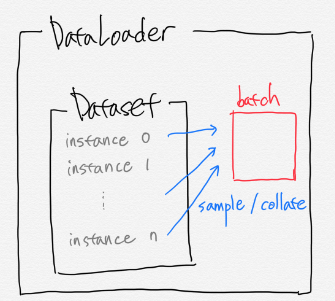

In [ ]:
#학습 데이터셋 구축
#ClassificationDataset -> 위에서 dataset 역할을 함
#-> 모든 인스턴스를 가지고 있다가 데이터 로더가 배치를 만들 때 인스턴스를 제공하는 일
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset
corpus = NsmcCorpus()
train_dataset = ClassificationDataset(
    args = args,
    corpus = corpus, #코퍼스-문장
    tokenizer = tokenizer,
    mode="train"
)

In [ ]:
#학습 데이터로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(
    train_dataset,
    batch_size = args.batch_size,
    sampler = RandomSampler(train_datset, replacement = False), #classificationdatset이 들고 있는 전체 인스턴스 가운데 배치사이즈만큼 비복원 랜덤추출
    collate_fn = nlpbook.data_collator, #위에서 뽑은 인스턴스를 배치로 만드는 역할
    drop_last = False,
    num_workers = args.cpu_workers,
)

In [ ]:
#평가용 데이터로더 구축
#학습용때와 다르게 sequential를 쓰는데, 배치구성을 랜덤으로 하는게 좋긴한데, 평가할때는 평가용데이터 전체를 사용하기 때문에 굳이 랜덤으로 사용할 필요가 없음
from torch.utils.data imort SequentialSampler 
val_dataset = ClassificationDataset(
    args = args,
    corpus = corpus,
    tokenizer = tokenizer,
    mode="test",
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size = args.batch_size,
    sampler = SequentialSampler(val_dataset),
    collate_fn = nlpbook.data_collator,
    drop_last = False,
    num_workers=args.cpu_workers,
)

In [ ]:
# 모델 불러오기 - 모델 초기화
#args -> pretrained_model_name= "beomi/kcbert-base",

from transformers import BertConfig, BertForSequenceClassification

pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels = corpus.num_labels,
)
model= BertForSequenceClassification.from_pretrained(
    args.pretrained_model_name,
    config = pretrained_model_config,
)


### 모델 학습시키기
- 파이토치 라이트닝이 제공하는 LightningModule 클래스를 상속받아서 태스크 정의

In [ ]:
#task정의
from ratsnlp.nlpbook.classification import ClassificationTask
task = ClassificationTask(model, args)

In [ ]:
#트레이너 정의
trainer = nlpbook.get_trainer(args)

In [ ]:
#학습 개시
trainer.fit(
    task, 
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
)